In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

In [10]:
import itertools as it
from collections import Counter, defaultdict, deque

In [15]:
# ---------- Functional programming tools ---------- #
from toolz.curried import *
max = curry(max)
min = curry(min)
call = lambda f: f()
@curry
def attr(name, obj):
    return getattr(obj, name)
@curry
def invoke(name, obj):
    return getattr(obj, name)()

lmap = curry(compose(list, map))
amap = curry(compose(np.array, list, map))

In [16]:
def load_vectors(file):
    result = {}
    for line in open(file):
        word, vec = line.split(' ', 1)
        result[word] = np.array(lmap(float, vec.strip().split(' ')))
    return result

vec = load_vectors('glove.6B/glove.6B.100d.txt')

In [17]:
features = [
    'arm',
    'auditory',
    'finger',
    'foot',
    'hand',
    'language',
    'memory',
    'music',
    'semantic',
    'speech',
    'syntactic',
    'visual',
]

In [18]:
def fmatrix(func):
    """Returns matrix of func applied to all pairs of features."""
    X = np.array([[func(a, b) for b in features]
                     for a in features])
    return pd.DataFrame(X, columns=features, index=features)

from scipy.spatial.distance import cosine
W = fmatrix(lambda a, b: cosine(vec[a], vec[b]))

## fMRI space with BrainMatrix

In [19]:
from brain_matrix import BrainMatrix
matrix = BrainMatrix(metric='emd', downsample=10, name='example', auto_save=False)
matrix.compute_distances(features)
B = matrix.to_dataframe()

100%|██████████| 66/66 [03:00<00:00,  2.73s/it]


In [261]:
import sklearn
def mds(X):
    m = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed")
    return m.fit(X).embedding_

def cluster(X, k=4):
    clustering = sklearn.cluster.AgglomerativeClustering(
        linkage='complete', affinity='precomputed', n_clusters=k
    )
    return clustering.fit_predict(X)

In [262]:
from scipy.spatial import procrustes
pW, pB, disparity = procrustes(mds(W), mds(B))
print(disparity)

0.580851160286


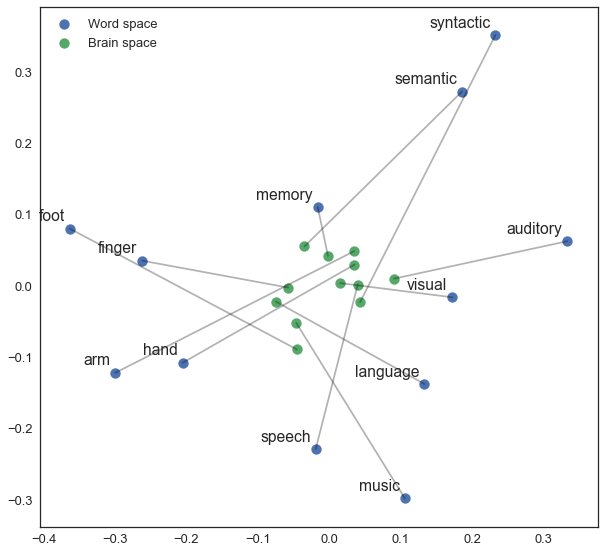

In [256]:
fig, ax = plt.subplots(figsize=(10, 10))

xW, yW = pW.T
xB, yB = pB.T

for i in range(len(pW)):
    plt.plot([xW[i], xB[i]], [yW[i], yB[i]], c='k', alpha=.3)
    
plt.scatter(xW, yW, s=100, label='Word space')
plt.scatter(xB, yB, s=100, label='Brain space')
plt.legend()

for label, x, y in zip(W.index, xW, yW):
    plt.annotate(label, xy = (x, y), xytext = (-5, 5),
                 textcoords = 'offset points', ha = 'right', va = 'bottom')
ax.set_aspect('equal')
plt.savefig('words-brains.pdf')

In [263]:
def z_to_sets(z):
    return [set(np.nonzero(z == i)[0])
            for i in range(max(z)+1)]

def sets_to_z(s):
    n = max(concat(s)) + 1
    z = np.zeros(n, dtype=int)
    for i, idx in enumerate(s):
        z[list(idx)] = i
    return z

def objective(s1, s2):
    return sum(len(x1 & x2) for (x1, x2) in zip(s1, s2))

def match_clusters(z1, z2):
    s1, s2 = map(z_to_sets, (z1, z2))
    s2_alt = max(it.permutations(s2),
                 key=lambda x: objective(s1, x))
    return tuple(map(sets_to_z, (s1, s2_alt)))


In [272]:
count(it.permutations('abc'))

6

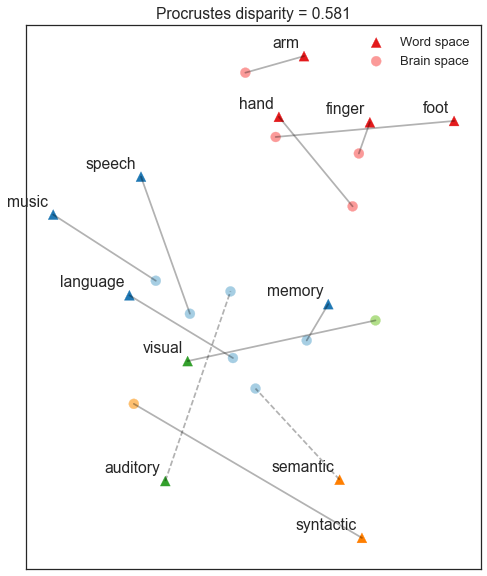

In [267]:
fig, ax = plt.subplots(figsize=(10, 10))
c = sns.color_palette('Paired', 8)
dark = np.array(c[1::2])
light = np.array(c[0::2])

xW, yW = pW.T
xB, yB = pB.T
zW, zB = match_clusters(*map(cluster, (W, B)))

plt.scatter(xW, yW, s=100, c=dark[zW], marker='^', label='Word space')
plt.scatter(xB, yB, s=100, c=light[zB], label='Brain space')

for i in range(len(pW)):
    plt.plot([xW[i], xB[i]], [yW[i], yB[i]], c='k', alpha=.3,
             ls='-' if zW[i] == zB[i] else '--')

for label, x, y in zip(W.index, xW, yW):
    plt.annotate(label, xy = (x, y), xytext = (-5, 5),
                 textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.legend()
plt.yticks([])
plt.xticks([])
ax.set_aspect('equal')
plt.title('Procrlustes disparity = {:.3f}'.format(disparity))
plt.savefig('words-brains.eps')